# 5. 損失はおいくら？

# 5.1 はじめに

## 推定結果をそのまま使うではなく、意思決定が及ぼす影響を重要視したほうが良い

ex.) ハリケーンが街を襲わない確率は99~100%で、そうなる確信度は９５%だ！といって何もしてなかったらハリケーンに襲われて街が壊滅した。何もしなかった時の損失を考慮しておきたい。

---

# 5.2 損失関数

$$L(\theta, \hat{\theta}) = f(\theta, \hat{\theta})$$

真のパラメータ $\theta$とそのパラメータの推定値 $\hat{\theta}$による関数。

損失関数は現在の推定値がどれぐらい間違ってるかを図る指標。損失が大きければ、推定値は悪いと言える。

### 損失関数色々

#### 1. 二乗誤差

$$L(\theta, \hat{\theta}) =  (\theta - \hat{\theta})^2$$

差の二乗に比例して損失が増加する。線形回帰や機械学習などで利用される。

#### 2. 非対称二乗誤差
$$
\begin{eqnarray}
L(\theta, \hat{\theta})=\left\{ \begin{array}{ll}
(\theta - \hat{\theta}) ^2 & (\hat{\theta} < \theta) \\
c(\theta - \hat{\theta}) ^2 & (\theta \geq \hat{\theta}) & and  & 0 < c < 1 \\
\end{array} \right.
\end{eqnarray}
$$

推定値が真のパラメータのほうが大きい方が望ましい状況の時、そのようなときに1未満の重みつけたりする。

#### 3. 絶対損失

$$ L(\theta, \hat{\theta}) = |\theta - \hat{\theta} | $$

二乗誤差は推定値が大きくなると損失が二乗に比例して大きくなっちゃうので外れ値に影響されやすい。そういう状況が嫌なときは差の絶対値だけを使う。

#### 4. 交差エントロピー損失
$$ 
L(\theta, \hat{\theta}) = - \hat{\theta} \log(\theta) - (1 - \hat{\theta}) \log(1 - \theta) \quad  \hat{\theta} \in \{ 0, 1\} ,  \theta \in \{ 0, 1\}
$$

分類問題の損失関数としてよく使われる

### 5.2.1 現実世界の損失関数

現実世界では真のパラメータ $\theta$を知ることはできない。知ることができるのは $\hat{\theta}$の事後分布。

$P(\theta | X)$ をXを観測した時の$\theta$の事後分布とすると、以下の式は「$\theta$に対する推定値$\hat{\theta}$についての期待損失」と解釈できる。

$$
l(\hat{\theta}) = E_\theta \bigl( L(\theta, \hat{\theta}) \bigr)
$$

この式は大数の法則から以下のように近似できる
$$
l(\hat{\theta}) = E_\theta \bigl( L(\theta, \hat{\theta}) \bigr) \approx \frac{1}{N} \sum^N_{i=1} L(\theta_i, \hat{\theta})
$$
ここで、$\theta_i (i = 1, ..., N)$は事後分布からのN個のサンプル。

最初の例で言うと、損失関数内で街の被害を数値化し、損失関数を組み込んでいれば、ただ単に確率だけの話ではなく結果の影響まで考慮してより良い判断ができそうである。

---

### 5.2.2 例題: テレビ番組 "The Price Is Right"の最適化

#### The Price Is Right（アメリカのテレビ番組）
1. 番組には２人の出演者
2. それぞれの出場者には、別々の賞金が２つずつ提示される
3. それを見た後、出場者はそれぞれ２つの商品の合計価格を予想する
4. 予想した価格が実際の合計価格を上回った場合、失格となる
5. 予想価格と実際の価格の差が２５０ドル未満であれば、相手の分の商品も獲得できる

この問題は２つの価格の合計を予測するものである。簡単のため、商品価格は正規分布に従うとすると
$$
True Price \sim Normal(\mu_p, \sigma_p)
$$

賞品も正規分布に従うと仮定すると
$$
Price_i \sim Normal(\mu_i, \sigma_i) \quad (i=1, 2)
$$

ここで賞品１は平均3000ドル、確信度500ドル、賞品２は平均12000ドル、確信度3000ドルとしてみる。

最終的な予測価格は賞品1 + 賞品２ + $\epsilon$と計算できる。 $\epsilon$は誤差。

また過去の実績から賞品の合計値は平均35000、確信度7500とわかってるものとする。

In [1]:
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
figsize(12.5, 9)
norm_pdf = stats.norm.pdf

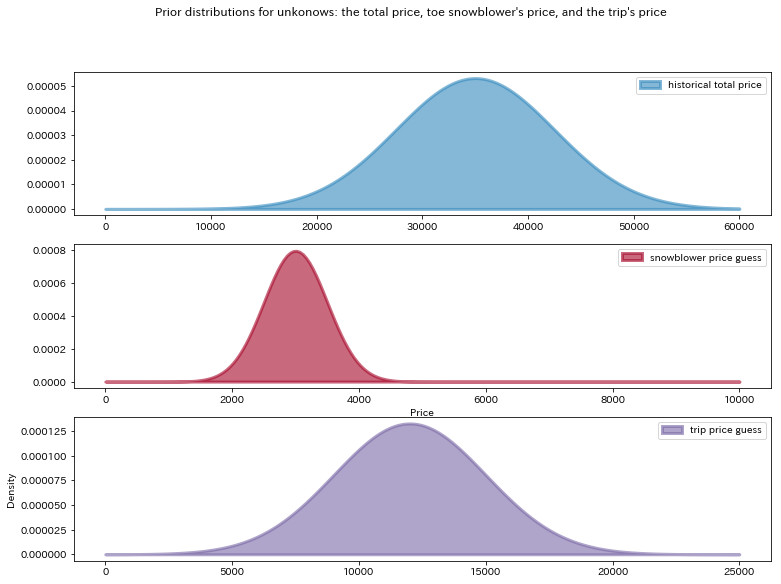

In [4]:
plt.subplot(311)
x = np.linspace(0, 60000, 200)
plt.fill_between(x, 0, norm_pdf(x, 35000, 7500), color='#348ABD', lw=3, alpha=0.6, label='historical total price')
plt.legend()

plt.subplot(312)
x = np.linspace(0, 10000, 200)
plt.fill_between(x, 0, norm_pdf(x, 3000, 500), color='#A60628', lw=3, alpha=0.6, label='snowblower price guess')
plt.xlabel('Price')
plt.legend()

plt.subplot(313)
x = np.linspace(0, 25000, 200)
plt.fill_between(x, 0, norm_pdf(x, 12000, 3000), color='#7A68A6', lw=3, alpha=0.6, label='trip price guess')
plt.legend()
plt.ylabel('Density')

plt.suptitle("Prior distributions for unkonows: the total price, toe snowblower's price, and the trip's price")

二つの商品の心の価格を推論してみる

In [8]:
import pymc as pm

data_mu = [3e3, 12e3]
data_std = [5e2, 3e3]
mu_prior = 35e3
std_prior = 75e2

true_price = pm.Normal('true_price', mu_prior, 1.0 / std_prior ** 2)
prize_1 = pm.Normal('first_prize', data_mu[0], 1.0 / data_std[0] ** 2)
prize_2 = pm.Normal('second_prize', data_mu[1], 1.0 / data_std[1] ** 2)
price_estimate = prize_1 + prize_2

@pm.potential
def error(true_price=true_price, price_estimate = price_estimate):
    return pm.normal_like(true_price, price_estimate, 1 / (3e3)**2)

mcmc = pm.MCMC([true_price, prize_1, prize_2, price_estimate, error])
mcmc.sample(50000, 10000)

 [-----------------100%-----------------] 50000 of 50000 complete in 5.3 sec

In [9]:
price_trace = mcmc.trace('true_price')[:]

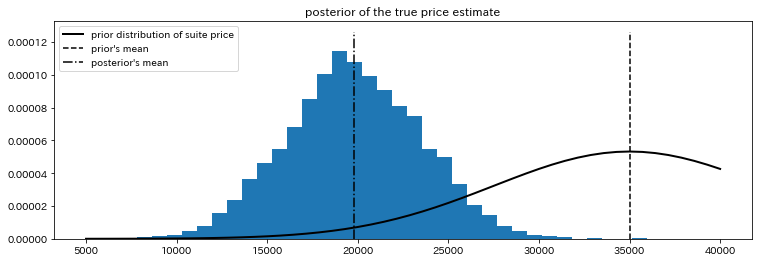

In [12]:
figsize(12.5, 4)
import scipy.stats as stats

x = np.linspace(5000, 40000)
plt.plot(x, stats.norm.pdf(x, 35000, 7500), c = 'k', lw=2, label='prior distribution of suite price')

_hist = plt.hist(price_trace, bins=35, normed=True, histtype='stepfilled')
plt.vlines(mu_prior, 0, 1.1 * np.max(_hist[0]), linestyles='--', label="prior's mean")
plt.vlines(price_trace.mean(), 0, 1.1 * np.max(_hist[0]), linestyles='-.', label="posterior's mean")

plt.title("posterior of the true price estimate")
plt.legend(loc='upper left')

頻度主義では過去のデータから$35,000と推定してしまうが、ベイズ推論を使用すると事後分布の平均が推定結果となる。

さらに、損失関数にドメイン特有の条件を加えることもできる。

In [21]:
def showcase_loss(guess, true_price, risk=80000):
    if true_price < guess:
        return risk
    elif abs(true_price - guess) <= 250:
        return -2 * np.abs(true_price)
    else:
        return np.abs(true_price - guess - 250)

この損失関数は、

- 推定結果が真の価格を上回ると適当に定めた大きな数字(risk)を返す
- 真の価格との差が250ドル以下の場合は真の価格２つ分の値を負の損失として返す。（賞品を２人分受け取れるので -2をかけてる）
- それ以外の場合は真の価格と推定価格の差が損失となる

riskの値によってこの損失関数がどのような形となるか見てみる

(5000, 30000)

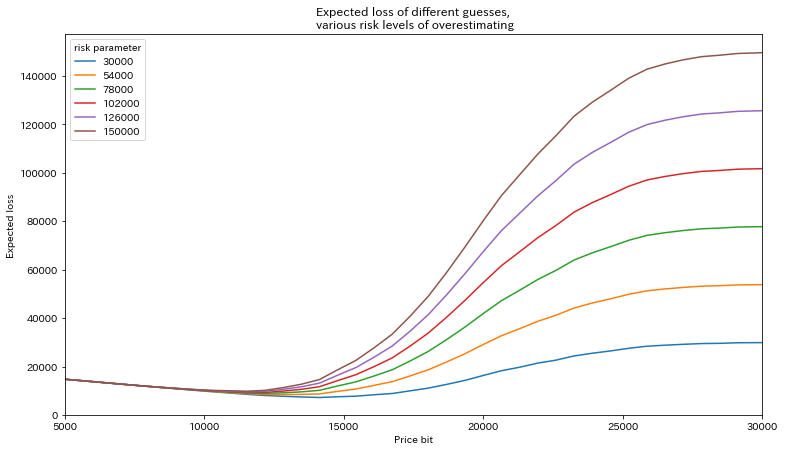

In [22]:
figsize(12.5, 7)

def showdown_loss(guess, true_price, risk=80000):
    loss = np.zeros_like(true_price)
    ix = true_price < guess
    loss[~ix] = np.abs(guess - true_price[~ix])
    close_mask = [abs(true_price - guess) <= 250]
    loss[close_mask] = -2 * true_price[close_mask]
    loss[ix] = risk
    return loss

guesses = np.linspace(5000, 50000, 70)
risks = np.linspace(30000, 150000, 6)

expected_loss = lambda guess, risk: showdown_loss(guess, price_trace, risk).mean()

for _p in risks:
    results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, results, label='%d'%_p)
    
plt.title("Expected loss of different guesses,\n various risk levels of overestimating")
plt.legend(loc="upper left", title="risk parameter")
plt.xlabel("Price bit")
plt.ylabel("Expected loss")
plt.xlim(5000, 30000)

この損失関数が最小となる推定値を求める。

期待損失を最小化する$\theta$は**ベイズ行動(bayes action)**と呼ばれる。scipyの最適化モジュールscipy.optimizeのfminで１発で求めることができる

minimum at ris 30000: 14174.98
minimum at ris 54000: 12615.83
minimum at ris 78000: 12282.77
minimum at ris 102000: 11650.14
minimum at ris 126000: 11650.14
minimum at ris 150000: 11650.14


(-1000, 80000)

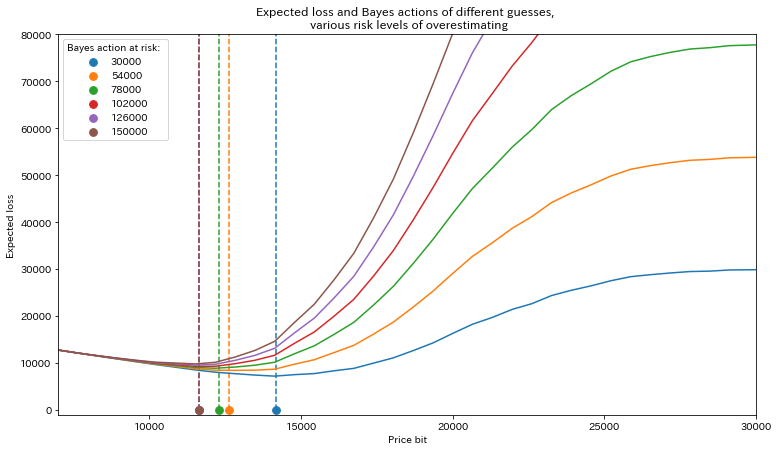

In [27]:
import scipy.optimize as sop

ax = plt.subplot(111)

for _p in risks:
    _color = next(ax._get_lines.prop_cycler)
    _min_results = sop.fmin(expected_loss, 15000, args=(_p, ), disp=False)
    _results = [expected_loss(_g, _p) for _g in guesses]
    
    plt.plot(guesses, _results, color=_color['color'])
    plt.scatter(_min_results, 0, s=60, color=_color['color'], label="%d"%_p)
    plt.vlines(_min_results, 0, 120000, color=_color['color'], linestyles="--")
    
    print("minimum at ris %d: %.2f"%(_p, _min_results))

plt.title("Expected loss and Bayes actions of different guesses, \n various risk levels of overestimating")
plt.legend(loc="upper left", scatterpoints=1, title="Bayes action at risk: ")
plt.xlabel("Price bit")
plt.ylabel("Expected loss")
plt.xlim(7000, 30000)
plt.ylim(-1000, 80000)

リスクを少なく見積もると高めの予測金額を取りやすくなる。

---

# 5.3 ベイズ手法を用いた機械学習

ベイズ行動を求めることはパラメータの精度ではなく、任意の性能評価指標を最適化するパラメータを求めることと等しい。←ちょっと何言ってるかわからないです

## 株価の予測

株価のリターンを予測する問題で、真のリターンが0.01だったとき二乗損失では-0.01と0.03と予測した損失は同一となる。
$$
(0.01 - (-0.01)) ^ 2 = (0.01 - 0.03) ^ 2 = 0.004
$$

しかし、-0.01と予測した場合は損失を被るし、0.03と予測した場合は利益を得る。このためより良い損失関数を考えたほうがいい

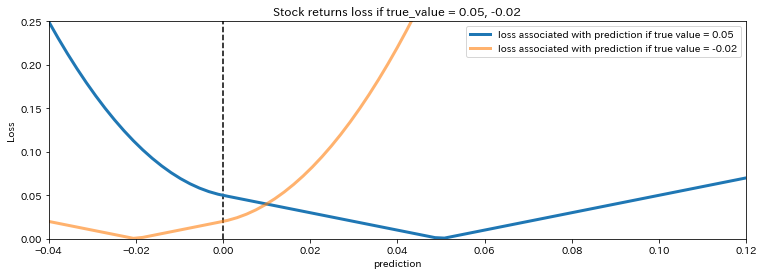

In [30]:
figsize(12.5, 4)

def stock_loss(true_return, yhat, alpha=100.):
    if true_return * yhat < 0:
        # 符号が異なる
        return alpha * yhat ** 2 - np.sign(true_return) * yhat + abs(true_return)
    
    else:
        return abs(true_return - yhat)
    
pred = np.linspace(-0.04, .12, 75)

true_value = 0.05
plt.plot(pred, [stock_loss(true_value, _p) for _p in pred], lw=3, label="loss associated with prediction if true value = 0.05")

true_value = -0.02
plt.plot(pred, [stock_loss(true_value, _p) for _p in pred], alpha=0.6, lw=3, label="loss associated with prediction if true value = -0.02")

plt.vlines(0, 0, 0.25, linestyles="--")
plt.xlabel("prediction")
plt.ylabel("Loss")
plt.xlim(-0.04, 0.12)
plt.ylim(0, 0.25)
plt.legend()
plt.title("Stock returns loss if true_value = 0.05, -0.02")

この損失関数は真の値から離れるほど損失が増えるが、符号を間違うとより損失が増える性質がある。

人口株式データに対して回帰を実行してみる

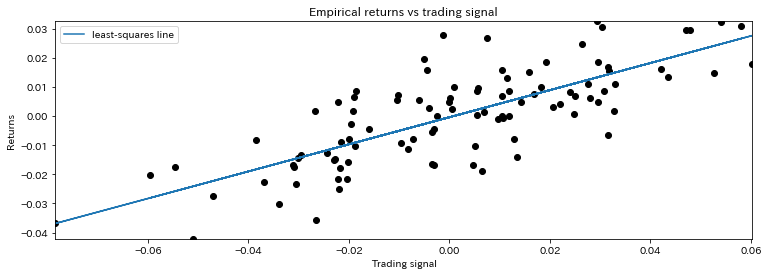

In [34]:
N = 100
X = 0.025 * np.random.randn(N)
Y = 0.5 * X + 0.01 * np.random.randn(N)

ls_coef_ = np.cov(X, Y)[0, 1] / np.var(X)
ls_intercept = Y.mean() - ls_coef_ * X.mean()

plt.scatter(X, Y, c='k')
plt.plot(X, ls_coef_*X + ls_intercept,  label= 'least-squares line')

plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())
plt.xlabel("Trading signal")
plt.ylabel("Returns")
plt.title("Empirical returns vs trading signal")
plt.legend(loc="upper left")

**ベイズ線形回帰**をこのデータセットに適用する。
$$
R = \alpha + \beta x + \epsilon
$$

$\alpha$, $\beta$が未知パラメータ、$\epsilon \sim Normal(0, 1 / \tau)$である。

$\alpha$, $\beta$の事前分布は正規分布とし、$\tau$も0~100の一様分布とする。（$\epsilon = 1/Uniform(0, 100) ^2$となる）

In [36]:
import pymc as pm

std = pm.Uniform("std", 0, 100, trace=False)

@pm.deterministic
def prec(U=std):
    return 1.0 / U**2

beta = pm.Normal("beta", 0, 0.0001)
alpha = pm.Normal("alpha", 0, 0.0001)

@pm.deterministic
def mean(X=X, alpha=alpha, beta=beta):
    return alpha + beta * X

obs = pm.Normal("obs", mean, prec, value=Y, observed=True)

mcmc = pm.MCMC([obs, alpha, beta, std, prec])
mcmc.sample(100000, 80000)

 [-----------------100%-----------------] 100000 of 100000 complete in 10.8 sec

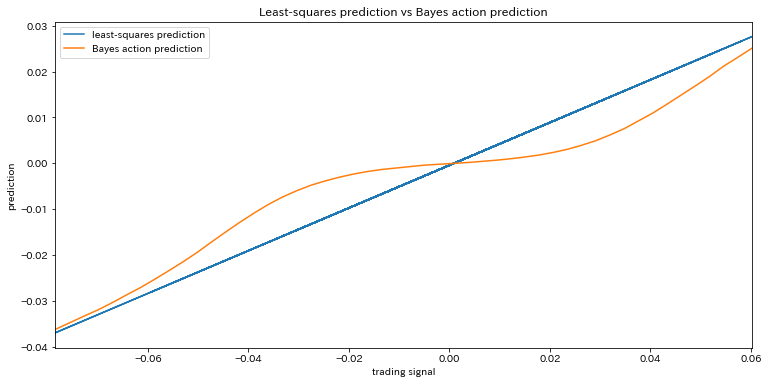

In [41]:
figsize(12.5, 6)

from scipy.optimize import fmin

def stock_loss(price, pred, coef=500):
    sol = np.zeros_like(price)
    ix = price*pred < 0
    sol[ix] = coef * pred ** 2 - np.sign(price[ix]) * pred + abs(price[ix])
    sol[~ix] = abs(price[~ix] - pred)
    return sol

tau_samples = mcmc.trace("prec")[:]
alpha_samples = mcmc.trace("alpha")[:]
beta_samples = mcmc.trace("beta")[:]

N = tau_samples.shape[0]

noise = 1. / np.sqrt(tau_samples) * np.random.randn(N)
possible_outcomes = lambda signal: alpha_samples + beta_samples * signal + noise

opt_predictions = np.zeros(50)
trading_signals = np.linspace(X.min(), X.max(), 50)
for i, _signal in enumerate(trading_signals):
    _possible_outcomes = possible_outcomes(_signal)
    tomin = lambda pred: stock_loss(_possible_outcomes, pred).mean()
    opt_predictions[i] = fmin(tomin, 0, disp=False)

plt.plot(X, ls_coef_ * X + ls_intercept, label="least-squares prediction")
plt.plot(trading_signals, opt_predictions, label="Bayes action prediction")

plt.xlim(X.min(), X.max())
plt.xlabel("trading signal")
plt.ylabel("prediction")
plt.title("Least-squares prediction vs Bayes action prediction")
plt.legend(loc="upper left")

最小二乗法における結果との比較として、損失関数を符号を間違えるとペナルティを与えるように設定したことから0近辺のところでは0と予測し、大きく変動しそうなところでは予測をし始めるという特徴をもっている点がある。

実運用として損失関数をどのように定義するかが大事ということをいいたいのではないかな。
ちゃんとうまくデータを表現できているのは最小二乗法の損失関数だが、株の運用という点まで考えると符号を間違えないようにする損失関数のほうが良いと言える。

---

## 5.3.2 ダークマターの観測

宇宙にあるダークマター（観測できないよくわからない物質。時空を歪める性質を持つらしい。アニメとか漫画の能力名に使われるらしい。）がどこに存在するかを予測するコンペがKaggleにある。ダークマターが大量に集まって形成する構造はダークマターハロー（ハロー）という。
優勝者のTimさんの手法はベイズ推論を用いてハローの場所を求めた。
これからその手法を実際に見てみる

- ハローの位置の事前分布$p(x)$を構築する。つまり、データを観測する前に期待される位置を定式化する。
- ダークマターの位置$x$が与えられた時、観測データ$e$に対する確率モデル$p(e | x)$を構築する。
- ベイズの定理を適用してハローの事後分布 $p(e | x)$を求める。
- 事後分布に基づいて、ハローの予測位置に対する期待損失を最小化する


In [42]:
from os import makedirs

makedirs("data/Train_Skies/Train_Skies", exist_ok=True)

In [43]:
from urllib.request import urlretrieve

urlretrieve("https://git.io/vXLqk", "data/Train_Skies/Train_Skies/Training_Sky3.csv")
urlretrieve("https://git.io/vXLqU", "draw_sky2.py")

('draw_sky2.py', <http.client.HTTPMessage at 0x11b043a90>)

In [44]:
from draw_sky2 import draw_sky

n_sky = 3
data = np.genfromtxt('./data/Train_Skies/Train_Skies/Training_Sky3.csv', dtype=None, skip_header=1, delimiter=',', usecols=[1,2,3,4])

In [45]:
print("Data on galaxies in sky %d."%n_sky)
print("position_x, position_x, position_y, e_1, e_2")
print(data[:3])

Data on galaxies in sky 3.
position_x, position_x, position_y, e_1, e_2
[[  1.62690000e+02   1.60006000e+03   1.14664000e-01  -1.90326000e-01]
 [  2.27228000e+03   5.40040000e+02   6.23555000e-01   2.14979000e-01]
 [  3.55364000e+03   2.69771000e+03   2.83527000e-01  -3.01870000e-01]]


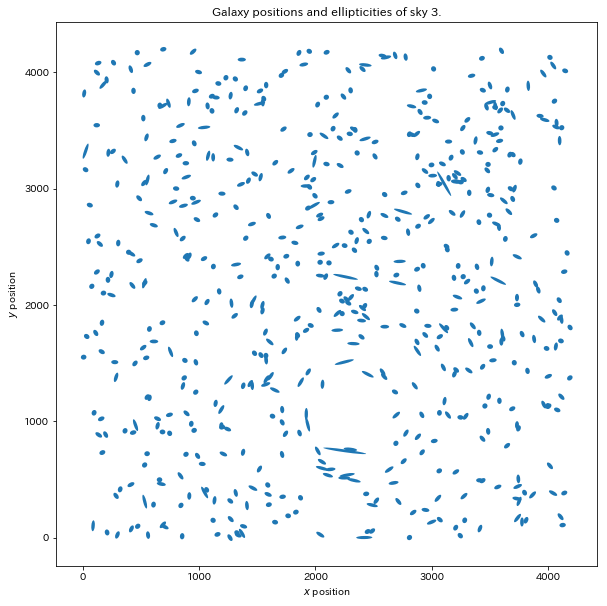

In [48]:
fig = draw_sky(data)
plt.xlabel("$x$ position")
plt.ylabel("$y$ position")
plt.title("Galaxy positions and ellipticities of sky %d."%n_sky)

### 事前分布

各天空ファイルには1~3のダークマターハローが含まれていて、ハローの位置の事前分布として一様分布を用いている

$$
x_j \sim Uniform(0, 4200)
$$
$$
y_j \sim Uniform(0, 4200)
$$
$$
(j = 1, 2, 3)
$$

ハローは大きな質量をもち、周辺の銀河にも大きな影響を与える。そこで、ハローの質量は40~180までの対数一様分布に従うと考えた。
$$
m_{large} = \log Uniform(40, 180)
$$

そのあと、ハローの楕円率はハローの一夜銀河との距離、質量に依存すると考え以下の式を考えた

$$
e_i | (x, y)  \sim Normal(\sum_{j=ハロー番号}d_{i, j} m_j f(r_{i, j}), \sigma^2)
$$

ここで$d_{i, j}$は$i$番目の銀河の光が$j$番目のハローで曲げられる方向、$m_j$は$j$番目のハローの質量、$f(r_{i,j})$はハロー$j$と銀河$i$のユークリッド距離$r_{i,j}$に関する損失関数を表す。

関数$f$は、大きいハローの場合
$$
f(r_{i, j}) = \frac{1}{min(r_{i, j}, 240)}
$$

小さいハローの場合
$$
f(r_{i, j}) = \frac{1}{min(r_{i,j}, 70)}
$$
としているとのこと

ぶっちゃけもう意味分からない

In [49]:
import pymc as pm

def euclidean_distance(x, y):
    return np.sqrt(((x-y)**2).sum(axis=1))

def f_distance(gyx_pos, halo_pos, c):
    return np.maximum(euclidean_distance(gyx_pos, halo_pos), c)[:, None]

def tangential_distance(glxy_position, halo_position):
    delta = glxy_position - halo_position
    t = (2 * np.arctan(delta[:, 1]/delta[:, 0]))[:, None]
    return np.concatenate([-np.cos(t), -np.sin(t)], axis=1)

In [50]:


mass_large = pm.Uniform("mass_large", 40, 180, trace=False)
halo_position = pm.Uniform("halo_position", 0, 4200, size=(1, 2))

@pm.deterministic
def mean(mass=mass_large, h_pos=halo_position, glx_pos=data[:, :2]):
    return mass / f_distance(glx_pos, h_pos, 240) * tangential_distance(glx_pos, h_pos)

ellpty = pm.Normal("ellipticity", mean, 1. / 0.05, observed=True, value=data[:, 2:])

model = pm.Model([ellpty, mean, halo_position, mass_large])
map_ = pm.MAP(model)
map_.fit()

mcmc = pm.MCMC(model)
mcmc.sample(200000, 140000, 3)

 [-----------------100%-----------------] 200000 of 200000 complete in 72.6 sec

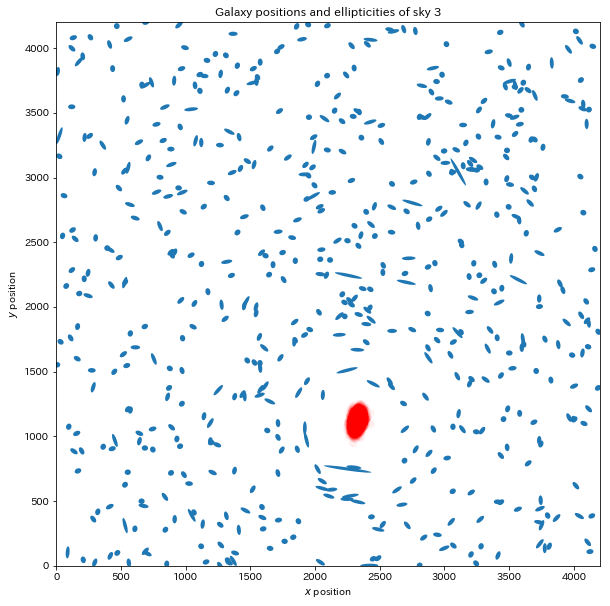

In [51]:
fig = draw_sky(data)

t = mcmc.trace("halo_position")[:].reshape(20000, 2)
plt.scatter(t[:, 0], t[:, 1], alpha=0.015, c="r")

plt.xlim(0, 4200)
plt.ylim(0, 4200)
plt.xlabel("$x$ position")
plt.ylabel("$y$ position")
plt.title("Galaxy positions and ellipticities of sky %d"%n_sky)

この赤いところにダークマターがありそうと言う感じである。
実際にハローの位置が乗っているデータを重ねてみる。

In [52]:
urlretrieve("https://git.io/vXLm6", "data/Training_halos.csv")

('data/Training_halos.csv', <http.client.HTTPMessage at 0x12a436470>)

In [55]:
halo_data = np.genfromtxt('./data/Training_halos.csv', delimiter=",", skip_header=1, usecols=[1,2,3,4,5,6,7,8,9])

print(halo_data[n_sky])

[  1.00000000e+00   1.40861000e+03   1.68586000e+03   1.40861000e+03
   1.68586000e+03   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]


True halo position:  2315.78 1081.95


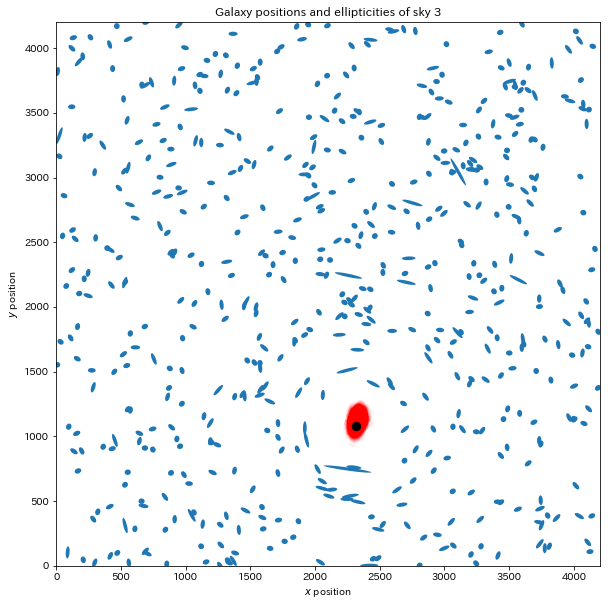

In [56]:
fig = draw_sky(data)

plt.scatter(t[:, 0], t[:, 1], alpha=0.015, c="r")
plt.scatter(halo_data[n_sky - 1][3], halo_data[n_sky - 1][4], label="true halo position", c="k", s=70)

plt.xlim(0, 4200)
plt.ylim(0, 4200)
plt.xlabel("$x$ position")
plt.ylabel("$y$ position")
plt.title("Galaxy positions and ellipticities of sky %d"%n_sky)

print("True halo position: ", halo_data[n_sky-1][3], halo_data[n_sky - 1][4])

具体的な場所を示すため、損失関数を使い位置を最適化する。

In [57]:
mean_posterior = t.mean(axis=0).reshape(1, 2)
print(mean_posterior)

[[ 2324.75289671  1124.40679276]]


まぁ悪くない

In [58]:
urlretrieve("https://git.io/vXLmx", "DarkWorldsMetric.py")

('DarkWorldsMetric.py', <http.client.HTTPMessage at 0x12a914b70>)

In [64]:
from DarkWorldsMetric import main_score
_halo_data = halo_data[n_sky - 1]

nhalo_all = _halo_data[0].reshape(1, 1)
x_ref_all = _halo_data[1].reshape(1, 1)
y_ref_all = _halo_data[2].reshape(1, 1)
x_true_all  = _halo_data[3].reshape(1, 1)
y_true_all  = _halo_data[4].reshape(1, 1)
sky_prediction = mean_posterior

print("Using the mean: ")
main_score(nhalo_all, x_true_all, y_true_all, x_ref_all, y_ref_all, sky_prediction)

print()

random_guess = np.random.randint(0, 4200, size=(1, 2))
print("Using the random location", random_guess)
main_score(nhalo_all, x_true_all, y_true_all, x_ref_all, y_ref_all, random_guess)

Using the mean: 
Your average distance in pixels you are away from the true halo is 43.3946094237
Your average angular vector is 1.0
Your score for the training data is 1.04339460942

Using the random location [[1281 1222]]
Your average distance in pixels you are away from the true halo is 1044.21437018
Your average angular vector is 1.0
Your score for the training data is 2.04421437018


2.0442143701845903

そこまで悪くない結果とのこと。

複数ダークマターがある銀河でも試してみる。

In [65]:
urlretrieve('https://git.io/vXqk4', "data/Train_Skies/Train_Skies/Training_Sky215.csv")

('data/Train_Skies/Train_Skies/Training_Sky215.csv',
 <http.client.HTTPMessage at 0x12aa8def0>)

In [99]:
def halo_posteriors(n_halos_in_sky, galaxy_data, samples=5e5, burn_in=34e4, thin=4):
    
    mass_large = pm.Uniform("mass_large", 40, 180)
    mass_small_1 = 20
    mass_small_2 = 20
    masses = np.array([mass_large, mass_small_1, mass_small_2], dtype=object)
    
    halo_positions = pm.Uniform("halo_positions", 0, 4200, size=(n_halos_in_sky, 2))
    fdist_constants = np.array([240, 70, 70])
    
    @pm.deterministic
    def mean(mass=masses, h_pos=halo_positions, glx_pos=galaxy_data[:, :2], n_halos_in_sky=n_halos_in_sky):
        _sum = 0
        for i in range(n_halos_in_sky):
            _sum += mass[i] / f_distance(glx_pos, h_pos[i, :], fdist_constants[i]) * tangential_distance(glx_pos, h_pos[i, :])
        
        return _sum
    
    ellpty = pm.Normal("ellipticity", mean, 1. / 0.05, observed=True, value=galaxy_data[:, 2:])
    model = pm.Model([ellpty, mean, halo_positions, mass_large])
    map_ = pm.MAP(model)
    map_.fit(method="fmin_powell")
    mcmc = pm.MCMC(model)
    mcmc.sample(samples, burn_in, thin)
    
    return mcmc.trace("halo_positions")[:]

In [100]:
n_sky = 215
data = np.genfromtxt('./data/Train_Skies/Train_Skies/Training_Sky215.csv', dtype=None, skip_header=1, delimiter=",", usecols=[1,2,3,4])
samples = 10.5e5

In [101]:
traces = halo_posteriors(3, data, samples, burn_in=9.5e5, thin=10)

/Users/RyotaKatoh/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 1050000 of 1050000 complete in 624.5 sec

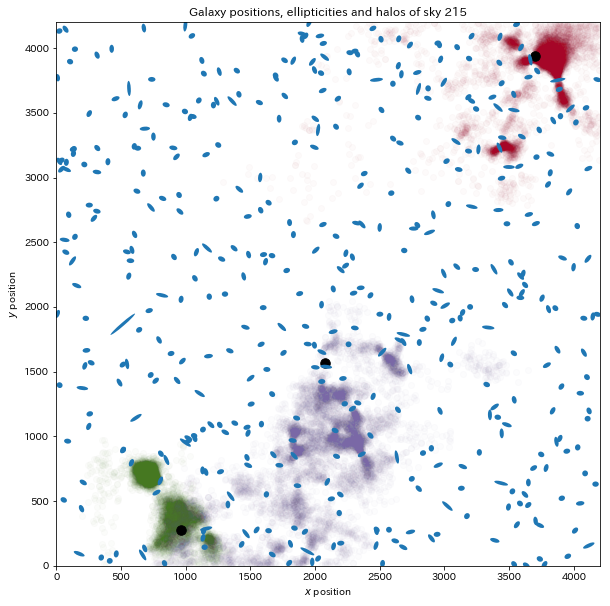

In [102]:
fig = draw_sky(data)

colors = ["#467821", "#A60628", "#7A68A6"]

for i in range(traces.shape[1]):
    plt.scatter(traces[:, i, 0], traces[:, i, 1], c=colors[i], alpha=0.02)

for i in range(traces.shape[1]):
    plt.scatter(halo_data[n_sky-1][3 + 2 * i], halo_data[n_sky-1][4 + 2*i], c="k", s=90, label="true halo position")
    
plt.xlim(0, 4200)
plt.ylim(0, 4200)
plt.xlabel("$x$ position")
plt.ylabel("$y$ position")
plt.title("Galaxy positions, ellipticities and halos of sky %d"%n_sky)

In [103]:
print(traces.shape)

(10000, 3, 2)


In [116]:
_halo_data = halo_data[n_sky - 1]

mean_posterior = traces.mean(axis=0).reshape(1, 6)

nhalo_all = _halo_data[0].reshape(1, 1)
x_ref_all = _halo_data[1].reshape(1, 1)
y_ref_all = _halo_data[2].reshape(1, 1)
x_true_all  = np.array([_halo_data[3], _halo_data[5], _halo_data[7]]).reshape(1, 3)
y_true_all  = np.array([_halo_data[4], _halo_data[6], _halo_data[8]]).reshape(1, 3)
sky_prediction = mean_posterior

print("Using the mean: ")
main_score(nhalo_all, x_true_all, y_true_all, x_ref_all, y_ref_all, sky_prediction)

print()

random_guess = np.random.randint(0, 4200, size=(1, 6))
print("Using the random location", random_guess)
main_score([1], x_true_all, y_true_all, x_ref_all, y_ref_all, random_guess)

Using the mean: 
Your average distance in pixels you are away from the true halo is 2133.39476523
Your average angular vector is 0.417372664049
Your score for the training data is 2.55076742928

Using the random location [[3397 4100 2212 3601 1295 2116]]
Your average distance in pixels you are away from the true halo is 338.55403483
Your average angular vector is 1.0
Your score for the training data is 1.33855403483


1.3385540348304832